In [1]:
from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 
import cv2
import matplotlib.pyplot as plt
from skimage import measure
import math
import scipy
import os
import sklearn
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
import pandas as pd
import torchvision.transforms as transforms
import glob
import shutil
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
from torch import optim
import torchvision

# Change file directory path here
All the results will be stored in cw_data directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Colab Notebooks/cs413/cw_data/DATA/"
try:
  results_dir = "/content/drive/MyDrive/Colab Notebooks/cs413/cw_data/results/"
  os.mkdir(results_dir)
except:
  pass

Mounted at /content/drive


# Data Preparation for model training
(hardly takes 1-2 minutes, as most of data preparation part is done in Task-1&2)

1.   utilizes all the train,val and test data created in task 1&2 
2.   shuffles all the data and resplit with conditions based on number of images in the class(Ids)
3. Creates a new data directory for resplitted train test and val data
4.  Creates annotation files for the same
5. Encodes the classes for model


To by-pass this data preparation, you can also download the entire training file from One-drive, shared with both TA's and Dr. Abhir Bhalerao.

link - https://livewarwickac.sharepoint.com/:u:/r/sites/IVAcoursework-2151556/Shared%20Documents/Training_data.zip?csf=1&web=1&e=FPsT8z

Run the next three snippets, and then jump to the data loader section 



In [6]:
img_label = [] # extract labels of all the images in prior created test train and val folder.
for data in ['train','val','test']:
  try:
    os.mkdir(f"{results_dir}{data}_new")
  except: pass
  for folder in glob.glob(f"{results_dir}{data}/*"):
    label = folder.split("/")[-1]
    for img_file in glob.glob(f"{folder}/*"):
        img_name = img_file.split("/")[-1]
        img_label.append([img_name,label,data])

In [7]:
annot_df = pd.DataFrame(img_label,columns=['img','label','data']) # dataframe with all the cards according to prior split
annot_df = annot_df[(annot_df.label!='000')] # exclude the unknown cards
classes = annot_df.label.unique()
len(classes)

104

In [8]:
label_mapping = {val:key for key,val in enumerate(annot_df.label.unique())}  # class to endoded value mapping
annot_df['new_label'] = annot_df.label.apply(lambda x: label_mapping[x])
annot_df.head()

,img,label,data,new_label
0,img_12_5.jpg,120,train,0
1,img_2_6.jpg,031,train,1
2,img_6_1.jpg,031,train,1
3,img_9_1.jpg,139,train,2
4,img_12_7.jpg,139,train,2


In [9]:
# Splits the data based on counts of cards in each label
train_df, test_df, val_df = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
for i in classes:
  tmp_df = annot_df[annot_df.label==i].sample(frac=1).reset_index(drop=True) # Shuffles the prior test-val-train split
  if len(tmp_df) == 1: # condition one - labels with just one card are kept to training dataset
    train_df = train_df.append(tmp_df)
  elif len(tmp_df) == 2: # codition two - if it has two cards, keeps one in train and the other in val
    train_df = train_df.append(tmp_df[tmp_df.index==0])
    val_df = val_df.append(tmp_df[tmp_df.index==1])
  elif len(tmp_df) == 3:
    train_df = train_df.append(tmp_df[tmp_df.index==0])
    val_df = val_df.append(tmp_df[tmp_df.index==1])
    test_df = test_df.append(tmp_df[tmp_df.index==2])
  else: # if greater than 3, then do a split of 80-10-10 in train-val-test
    for i,row in tmp_df.iterrows(): 
      if i<= int(0.8*len(tmp_df)):
        train_df = train_df.append(tmp_df[tmp_df.index==i])
      elif i>int(0.8*len(tmp_df)) and i <= int(0.9*len(tmp_df)):
        val_df = val_df.append(tmp_df[tmp_df.index==i])
      else:
        test_df = test_df.append(tmp_df[tmp_df.index==i])


In [10]:
# As in above logic more priority was given to val over test. so resplitting the test and val in 50-50
val_test_df = val_df.append(test_df).sample(frac=1).reset_index(drop=True)
val_df = val_test_df[val_test_df.index<=int(len(val_test_df)*0.5)]
test_df = val_test_df[val_test_df.index>int(len(val_test_df)*0.5)]

In [11]:
len(train_df),len(val_df),len(test_df) # this looks good

(238, 36, 35)

In [12]:
# replicating the cards in train dataset to the cards with lesser counts, 
# to have all the labels with equal number of cards
# could have done above while replitting but didn't want to keep duplicates in test and val
train_df = train_df.reset_index(drop=True)
train_aug_df = pd.DataFrame()
max_items = max(train_df.label.value_counts())
for i in classes:
  tmp_df = train_df[train_df.label==i].sample(frac=1).reset_index(drop=True)
  req_aug = max_items - len(tmp_df)
  new_tmp_df = tmp_df.copy()
  if req_aug > 0:
    for j in range(15):
      new_tmp_df = new_tmp_df.append(tmp_df)  
      if len(new_tmp_df)>=max_items:
        new_tmp_df = new_tmp_df.sample(frac=1).reset_index(drop=True).head(max_items)
        # print(len(new_tmp_df))
        break;
  
  train_aug_df = train_aug_df.append(new_tmp_df)

#train_aug_df.label.value_counts()  

In [13]:
# to copy the images from prior created folders in task 1,2 to new folders based on above split logic
#-- TRAIN -- 
train_aug_df = train_aug_df.reset_index(drop=True)

train_annot = []
for i,row in train_aug_df.iterrows():
  img_name = f"{i}_{row['img']}"
  shutil.copyfile(f"{results_dir}{row['data']}/{row['label']}/{row['img']}",
                  f"{results_dir}train_new/{img_name}"
                  )
  train_annot.append([img_name,row['new_label']])
#-- TEST -- 
for i,row in test_df.iterrows():
  img_name = f"{row['img']}"
  shutil.copyfile(f"{results_dir}{row['data']}/{row['label']}/{row['img']}",
                  f"{results_dir}test_new/{img_name}"
                  )
#-- VAL --   
for i,row in val_df.iterrows():
  img_name = f"{row['img']}"
  shutil.copyfile(f"{results_dir}{row['data']}/{row['label']}/{row['img']}",
                  f"{results_dir}/val_new/{img_name}"
                  )

In [14]:
# training annotation file with image and encoded label mapping
pd.DataFrame(train_annot,columns=['img','new_label']).to_csv(f"{results_dir}train_annot.csv",index=False)
# VAl and TEST annotation file with image and encoded label mapping
test_df[['img','new_label']].to_csv(f"{results_dir}test_annot.csv",index=False)
val_df[['img','new_label']].to_csv(f"{results_dir}val_annot.csv",index=False)

In [15]:
(len(glob.glob(f"{results_dir}train_new/*")),
len(glob.glob(f"{results_dir}test_new/*")),
len(glob.glob(f"{results_dir}/val_new/*")))

(1352, 35, 36)

#Dataloader

brings all the train test and val datasets in dataloader format

In [16]:
# A class to transform/augment the cards and bring datasets in dataloader format
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [17]:
# Used annotation files and new train-test-val data repository to bring datasets in dataloader format 


training_data = CustomImageDataset(
                  img_dir=f"{results_dir}train_new",
                  annotations_file = f"{results_dir}train_annot.csv",
                  transform=transforms.Compose([transforms.ToPILImage(), # trasformations on the images to enrich the training images
                                                transforms.Resize((224,224)), 
                                                #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                                                #transforms.RandomRotation(degrees=(0, 180)),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                )

val_data = CustomImageDataset(
    img_dir=f"{results_dir}val_new",
    annotations_file = f"{results_dir}val_annot.csv",
    transform=transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224,224)), 
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
)


test_data = CustomImageDataset(
    img_dir=f"{results_dir}test_new",
    annotations_file = f"{results_dir}/test_annot.csv",
    transform=transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224,224)), 
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
)

In [18]:

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

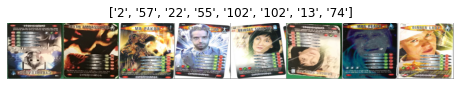

In [20]:
batch_size = 8
def imshow1(img, title):
    npimg = img.numpy() / 2 + 0.5 # undo the normallized image
    plt.figure(figsize=(batch_size,10)) # 
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transposes image to its x,y,channel dimensions
    plt.title(title) 
    plt.show()

images, labels = next(iter(test_dataloader)) # gets images and labels apart
img = torchvision.utils.make_grid(images) # make a grid view of all the images in the batch
imshow1(img, title=[str(x.item()) for x in labels])

# Model import and training
Used resnet50

Initiallizes loss function and Ompitimizer

In [21]:
# Importing Resnet Model
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
# GPU intiallisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for param in resnet.parameters(): # freezing all the parmeters
# param.requires_grad = False

n_classes = len(classes)
in_features = resnet.fc.in_features # updating the last layer to output the required dimension of labels
resnet.fc = nn.Linear(in_features,n_classes)

c = 0
for child in resnet.children():
  c += 1
  if c <= 8:
    for param in child.parameters():
      param.requires_grad = False

resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01) # Adam optimizer

cpu


In [23]:
# evaluates the models performace and returns accuracy
def evaluation(dataloader, model):
    total, correct,data_loss = 0, 0,0
    data_len = 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1) # similar to arg max
        loss = loss_fn(outputs, pred)
        data_len+= len(pred)
        #print(labels,pred)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        data_loss += loss.item()
    return (100 * correct)/total, data_loss/data_len

# Training the Model
train the model to update the wieghts of last two layers and save the best fit in result directory. 

**Important Note** - The best fit model is found to be RESNET50, which has state dictionary size of 88 Mb post compressing. (shared along with notebooks)

I have uploaded the same on one-drive and shared with both TAs and Dr. Abhir Bhalerao.

link https://livewarwickac.sharepoint.com/:u:/s/IVAcoursework-2151556/ERiCIw3O2F9EtTxukFTdpTcB3mdqKLDcffgnqa2igu0TFQ?e=0qry8c

OR, you can train the model for 30 epochs, should be done in less than 10 mins.

In [ ]:
# Training the Model
import copy
train_loss,val_loss = [],[]
train_acc,val_acc = [],[]
max_epochs = 100
min_loss = 1000
for epoch in range(max_epochs):
    loss_train = 0
    data_len = 0
    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
#         print(labels)
        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item(): # saves the best fit model
          min_loss = loss.item()
          best_model = copy.deepcopy(resnet.state_dict())

        loss_train += loss.item()
        data_len+= len(labels)
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    val_metrices = evaluation(val_dataloader, resnet)
    train_metrices = evaluation(train_dataloader, resnet)
    
    train_loss.append(loss_train/data_len)
    val_loss.append(val_metrices[1])

    # for i in test_dataloader:
    #   inp, lbls = i
    #   inp, lbls = inp.to(device), lbls.to(device)
    #   out = resnet(inp)
    #   _, prd = torch.max(out.data, 1)
    #   print(lbls,prd)

    
    train_acc.append(train_metrices[0])   
    val_acc.append(val_metrices[0])        
    
    print(f"epoch:{epoch},train_acc:{train_acc[-1]},val_acc:{val_acc[-1]}")
    

In [ ]:
# save the best fit and the last epoch model
torch.save(resnet.state_dict(),f"{results_dir}resnet50_lr01_sgd.pt")
torch.save(best_model,f"{results_dir}best_resnet50_lr01_sgd.pt")

**Uncomment the command below** to import the state dict of the model shared on One-drive. 

Update the path as per the file location


In [ ]:
# evaluation on test data
#resnet.load_state_dict(torch.load(f"{results_dir}best_resnet50_lr01_sgd.pt",map_location=torch.device('cpu')))
resnet.eval()
evaluation(test_dataloader,resnet)

(88.57142857142857, 0.020109171074415955)

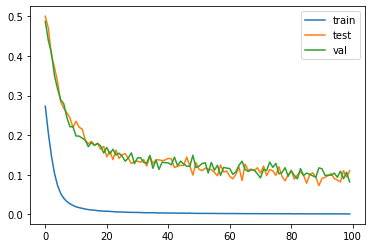

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train','val'])
plt.savefig(f"{results_dir}resnet50_lr01_sgd_loss.jpg")

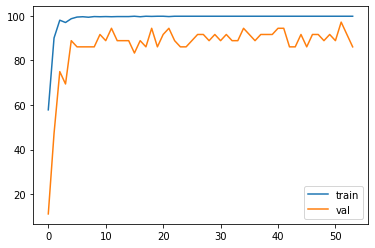

In [45]:
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['train','val'])
plt.savefig(f"{results_dir}resnet50_lr01_sgd_acc.jpg")